# Transfer learning in computer vision

> Fine-tuning a pretrained model on the pets dataset.

In [ ]:
from local.test import *
from local.basics import *
from local.callback.all import *
from local.vision.all import *

## Single-label classification

### Gathering the data

We use the data block API to get our data in a `DataBunch`. Here our inputs are images and our targets categories. The images are all in a folder, so we use `get_image_files` to collect them all, a `RandomSplitter` to split between training and validation, then we get the label from the filenames with a regex labeller.

In [ ]:
pets = DataBlock(types=(PILImage, Category), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'))

The pets object by itself is empty: it only containes the functions that will help us gather the data. We have to call its `datasource` or `databunch` method to get a `DataSource` or a `DataBunch`. The first thing we need to pass to either of those functions is the source, here the folder where all the images are. Then we specify some dataset transforms (a random resized crop to 300 by 300) and some dataloader transforms (basic data augmentation on the GPU and normalization using the imagenet statistics).

In [ ]:
dbunch = pets.databunch(untar_data(URLs.PETS)/"images", item_tfms=RandomResizedCrop(300, min_scale=0.5), bs=64,
                        batch_tfms=[*aug_transforms(size=224), Normalize(*imagenet_stats)])

Then we can look at some of our pictures with `dbunch.show_batch()`

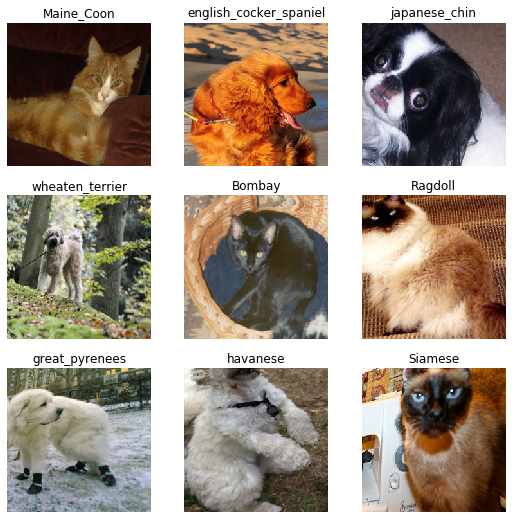

In [ ]:
dbunch.show_batch(max_n=9)

### Using a pretrained model

First let's import a `resnet34` form torchvision.

In [ ]:
from torchvision.models import resnet34

We will use the AdamW optimizer (Adam with true weight decay).

In [ ]:
opt_func = partial(Adam, lr=3e-3, wd=0.01)

Then we can call `cnn_learner` to build a `Learner` from our `DataBunch`. Since we are using a pretrained model, it comes automatically frozen, which means only the head is going to be trained.

In [ ]:
learn = cnn_learner(dbunch, resnet34, opt_func=opt_func, metrics=error_rate)

We can train the head a little bit using the 1cycle policy.

In [ ]:
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
ReLU                 64 x 64 x 56 x 56    0          False     
_____________________________________________________

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.458472,0.335746,0.105548,00:14


Then we can unfreeze the model and use discriminative learning rates.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.498007,0.306936,0.100135,00:17


### Seeing results

In [ ]:
learn.predict(dbunch.train_ds.items[0])

('boxer',
 tensor(16),
 tensor([3.5605e-04, 9.7266e-06, 9.0780e-07, 1.9909e-05, 4.9642e-06, 5.5649e-05,
         4.2863e-06, 1.1945e-04, 1.1487e-06, 1.5270e-05, 3.1729e-04, 6.3631e-04,
         1.0523e-04, 1.5598e-02, 7.6138e-04, 1.8013e-04, 5.3991e-01, 4.7377e-04,
         8.6227e-06, 5.3590e-05, 1.2035e-04, 1.2087e-05, 1.0975e-05, 5.4730e-06,
         7.9140e-06, 7.4904e-05, 4.3651e-01, 7.0852e-06, 1.0927e-05, 1.9865e-03,
         1.3393e-06, 3.2222e-06, 8.4794e-05, 2.9834e-04, 2.0334e-03, 1.1146e-04,
         9.3037e-05]))

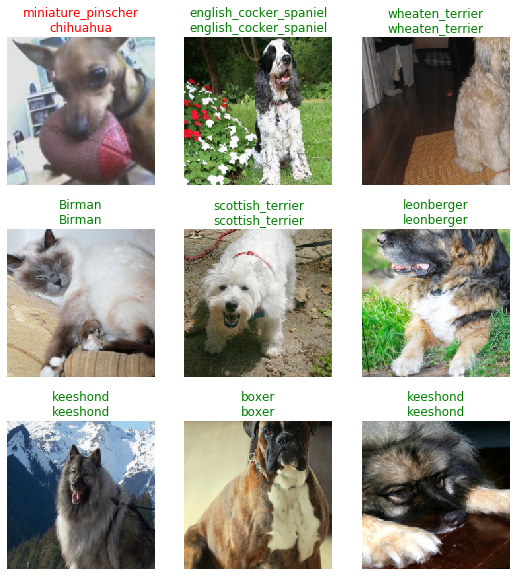

In [ ]:
learn.show_results(max_n=9)

## Multi-label classification

In [ ]:
MultiCategory.default_type_tfms = OneHotEncode

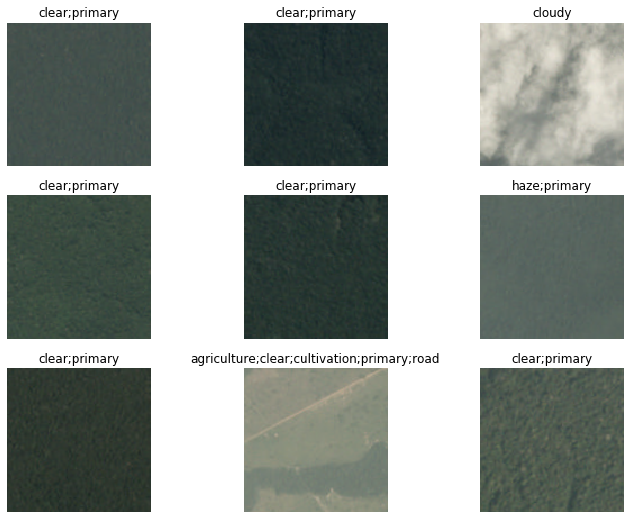

In [ ]:
planet_source = untar_data(URLs.PLANET_TINY)
df = pd.read_csv(planet_source/"labels.csv")

planet = DataBlock(types=(PILImage, MultiCategory),
                   get_x=lambda x:planet_source/"train"/f'{x[0]}.jpg',
                   splitter=RandomSplitter(),
                   get_y=lambda x:x[1].split(' '))

dbunch = planet.databunch(df.values,
         batch_tfms=aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.))
dbunch.show_batch(max_n=9, figsize=(12,9))

In [ ]:
learn = cnn_learner(dbunch, resnet34, opt_func=opt_func, metrics=accuracy_multi)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.994642,0.833695,0.539286,00:03


In [ ]:
learn.predict([dbunch.train_ds.items[0][0]]);

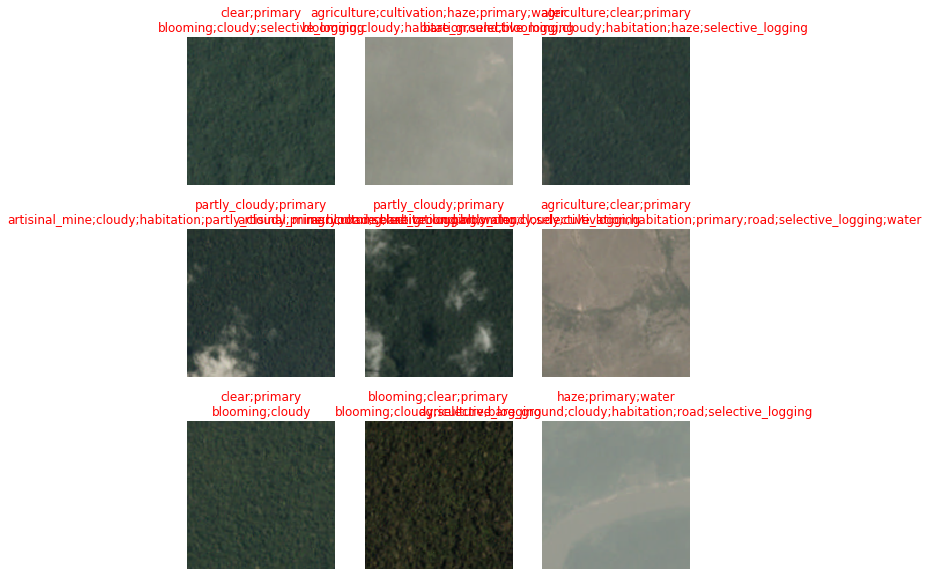

In [ ]:
learn.show_results(max_n=9)

## Segmentation

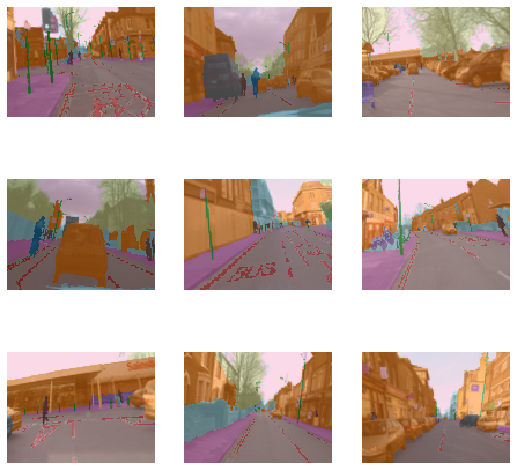

In [ ]:
camvid = DataBlock(types=(PILImage, PILMask),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=lambda o: untar_data(URLs.CAMVID_TINY)/'labels'/f'{o.stem}_P{o.suffix}')

dbunch = camvid.databunch(untar_data(URLs.CAMVID_TINY)/"images", batch_tfms=aug_transforms())
dbunch.show_batch(max_n=9, vmin=1, vmax=30)

In [ ]:
#TODO: Find a way to pass the classes properly
dbunch.vocab = np.loadtxt(untar_data(URLs.CAMVID_TINY)/'codes.txt', dtype=str)

In [ ]:
learn = unet_learner(dbunch, resnet34, opt_func=opt_func, config=unet_config())
learn.fit_one_cycle(1, 1e-3)
# Use the below to get somewhat reasonable results - but takes a bit longer
# learn.fit_one_cycle(8, 3e-3)

epoch,train_loss,valid_loss,time
0,3.567056,3.645283,00:03


In [ ]:
learn.predict(dbunch.train_ds.items[0]);

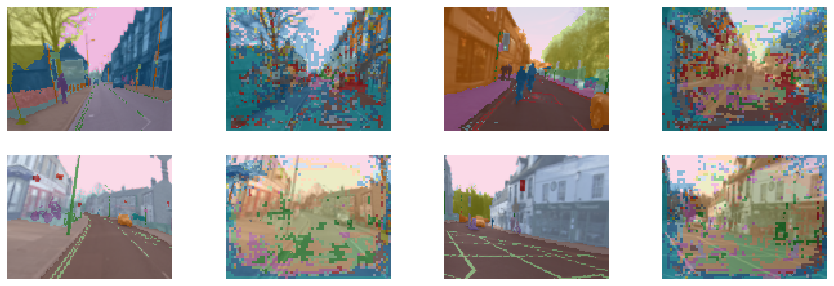

In [ ]:
learn.show_results(max_n=4, figsize=(15,5))

## Points

In [ ]:
path = untar_data(URLs.BIWI_SAMPLE)
fn2ctr = (path/'centers.pkl').load()

In [ ]:
fn2ctr['0.jpg'].flip(0)

tensor([84.8110, 84.0480])

In [ ]:
biwi = DataBlock(types=(PILImage, TensorPoint),
                 get_items = get_image_files,
                 get_y = lambda o:fn2ctr[o.name].flip(0),
                 splitter=RandomSplitter())

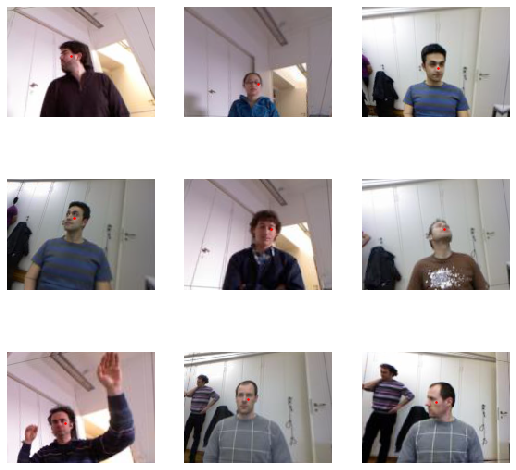

In [ ]:
dbunch = biwi.databunch(path, batch_tfms=[*aug_transforms(size=(120,160)), Normalize(*imagenet_stats)])
dbunch.show_batch(max_n=9, vmin=1, vmax=30)

In [ ]:
#TODO: look for attrs in after_item
dbunch.c = dbunch.after_item.c
dbunch.train_ds.loss_func = MSELossFlat()

In [ ]:
learn = cnn_learner(dbunch, resnet34, opt_func=opt_func)
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,time
0,3.674821,1.325863,00:03
1,3.921367,1.302436,00:03
2,3.313823,1.321183,00:03
3,3.501566,1.121827,00:03
4,3.290803,0.990803,00:03


In [ ]:
learn.predict(dbunch.train_ds.items[0])

(tensor([56.3922, 73.8480]),
 tensor([-0.2951,  0.2308]),
 tensor([-0.2951,  0.2308]))

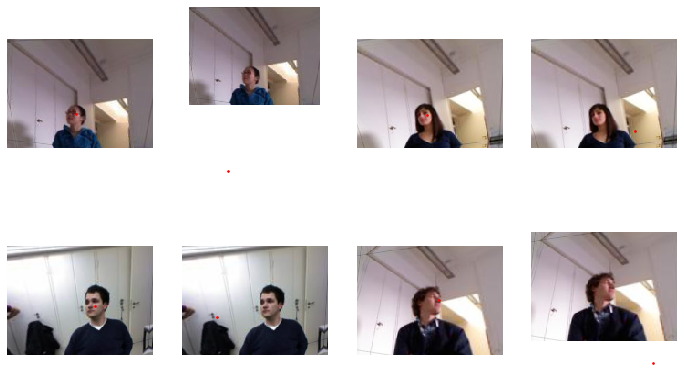

In [ ]:
learn.show_results(max_n=4)

### fin